# <a href="https://ramp.studio/">RAMP</a> early detection of type 2 Diabetes in a non-invasive fashion

_Authors:_
- AMANI Alexandre
- BISCARRAT Lilian
- CHAUSSARD Alexandre
- CLERGUE Eva
- NORMAND Sophie
- SALEMBIEN Tom

# Introduction

Diabetes is a growing disease, affecting over 10% of the worldwide population. The vast majority of diabetics are type 2 diabetics (96%), that is generally characterized by a resistance to insulin, or limited production of insulin by the pancreatic cells, which is a molecule that enables glucose to enter the cells and provide energy. Not being able to properly consume sugar results in several complications that are all tied up to the high sugar level concentration in the blood due to not being able to consume it, resulting in possible blindness, hearth disease, infections, and so on.

Therefore, it is one today's most important challenge to properly diagnose diabetics, as early as possible to prevent complications from settling. At the moment, diabetes is diagnosed in multiple ways, one of the most secure and proper one being HbA1c measurement from blood samples (glycohemoglobin). The measurement of HbA1c for a sain individual is around 5.7%, while it is said to be diabetic-like when it reaches 6.5% and more.

While this technique has proved to be really efficient in the diagnosis, it has one major downside that we would like to tackle in this study. Indeed, HbA1c reflects the last 3 months of blood sugar average, therefore, in order to see that diabetes has settled, the individual has to have been severly diabetic for 3 months at least. Moreover, there exists different severities of type 2 diabetes, resulting in sometimes having to be diabetic (or pre-diabetic) for an even longer period before HbA1c becomes significant. This delay in the diagnosis could severly impact the individual, with possible irrevertible side effects.

As a result, the goal of our study is to provide a machine learning algorithm that is able to predict whether or not somebody may become diabetic in the coming month or years, based on blood glucose measurements from a non-invasive Continuous Glucose Monitor (CGM), as well as gathered clinical data from the patient over 3 years. The goal of the algorithm is not to provide a diagnosis of the disease, but rather to unveil risky situations so that possibly future diabetics can be taken in charge before the disease settles and causes damages. Basically, it aims at detecting early stage diabetes so more tests can be ran by doctors and possibly give early treatement.

## Dataset Description

For this project, we use the data from the article of _Colas, A., Vigil, L., Vargas, B. Cuesta-Frau, D., Varela, M. (2019):  Detrended Fluctuation Analysis in the prediction of type 2 diabetes mellitus in patients at risk: Model optimization and comparison with other metrics_ (https://doi.org/10.1371/journal.pone.0225817). The dataset is composed of 208 individuals selected from January 2012 to May 2015 among patients of the clinic of hypertension and vascular risk of the University Hospital of Mostoles in Madrid. They were selected according to the following criteria: age between 18 and less than 85 years, previous diagnosis of essential hypertension, and exclusion of a diagnosis of diabetes mellitus or treatment with antidiabetic drugs. For those patients, we have two types of information: clinical data and continuous glucose monitoring (CGM) data.

CGM sensors are small wearable devices that enables the measurement of interstitial blood glucose (in mg/dL) every 5 minutes at any time of the day in the daily life of the patient. It consists in a small patch one can place at define places of the body, which measures blood glucose through a small electrode placed in the device and directly in the interstitial fluid. The one that is used here is the iPro, while most common brands are FreeStyle Libre or Dexcom CGMs. Despites having these time series at our disposal, there is no general consensus for now on how to analyze glucose time series (see paper), because of their novator aspect in glucose measurement, and their returned information that can be difficult to interpret at first glance since the measurements are not directly taken in blood but in interstitial fluid.

For each patient in our dataset, we have at least 24h of CGM data, with measurement of glucose values each 5 minutes. After the registration of these measures, the patients were followed every 6 months in the clinic, until they were diagnosed type 2 diabetic or not by the end of the study (33 months). The diagnosis of Type 2 diabetes was done with the HbA1c test as detailed previously (diabetes if superior to 6.5%) and/or with a basal glycemia test (diabetes if superior to 126 mg/dL). Finally, 17 patients were diagnosed with Type 2 diabetic. The objective of this project is to introduce data science tools and approaches to see if we can detect patients with coming type 2 diabetes using CGM and clinical data that might be related to diabetes: age, sex, BMI, basal glycemia (fasting blood glucose). 

# Getting started with the RAMP starting kit

## Software prerequisites

This starting kit requires the following dependencies:
- numpy
- pandas
- scikit-learn
- matplolib
- jupyter
- torch
- seaborn


## Getting the data

The data are available in the `data` source folder.

## Explore the dataset

### Clinical data

We start with an inspection of the raw clinical dataset.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from download_data import read_raw_clinical_data

X = read_raw_clinical_data()
y = X["T2DM"].values

print(f"Number of DT2 diagnosed patients: {str(y.sum())}/{len(y)}")
print(f"Proportion of DT2 diagnosed patients: {str(y.sum()/len(y) * 100)[:4]}%")

Number of DT2 diagnosed patients: 17/208
Proportion of DT2 diagnosed patients: 8.17%


In [2]:
X.head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
1,1,77,25.4,106,6.3,False
2,0,42,30.0,92,5.8,False
3,0,61,33.8,114,5.5,False
4,0,67,26.7,110,6.0,False
5,1,53,25.8,106,5.2,False


The features given by each column correspond to clinical observations on the patient:
- **gender**: gender of the patient (1: woman, 0: man)
- **age**: age of the patient (in years)
- **BMI**: body mass index (kg/m², weight/height²)
- **glycaemia**: basal glycaemia (mg/dL) (fasting blood glucose, it reflects the residual sugar level when no insulin is produced)
- **HbA1c**: glycohemoglobin measurement at the beginning of the study (%)
- **TD2M**: type 2 diabetes mellitus diagnosis (label)

Looking at the gender distribution, it seems that it is balanced, however we have much more diabetics that are men, with a factor 2 almost between the two. Therefore, in terms of application, one should be careful if the gender is determinant in the prediction.

We should verify that situation when producing a final model.

In [3]:
X["gender"].value_counts()

1    105
0    103
Name: gender, dtype: int64

In [4]:
X[["gender", "T2DM"]].groupby(by="gender").sum()

,T2DM
gender,
0,11
1,6


We need to check for possible missing data in our samples. The following table gives the raw missing data.

In [5]:
X[X.isna().any(axis=1)].head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
68,0,71,27.9,109,NaN,False
91,1,72,NaN,96,5.7,False
94,1,53,43.9,82,NaN,False
95,1,61,35.3,102,NaN,False
96,0,48,21.2,105,NaN,False


Since we have the CGM entries, we can possibly estimate the missing HbA1c values, even though we don't have 3 months of CGM entries, it is still our best shot at having a medically verified imputer here.

However, we can not infer the BMI missing entry using external data, so we will try filling it using different imputers in the next section.

#### BMI: One missing value

Looking at the overall clinical data, we notice that we have a unique missing value for a BMI entry.

In [6]:
X[X["BMI"].isna()].head()

,gender,age,BMI,glycaemia,HbA1c,T2DM
91,1,72,NaN,96,5.7,False


We propose different approaches to fill the BMI missing value.

##### Method 1: Imputation using the mean, with handcrafted prior

We impute the missing value of the feature BIM by the average BIM of individuals of the same age and gender (handcrafted prior). 

As we can see on the following table, we do have some very similar individuals to enable us to safely determine the missing value. Luckily, we also have that the missing value entry has the same type 2 diabetes diagnosis of the others, which may be an additional prior item to compliment our imputation using the mean. 

In [7]:
X[(X["age"]==72) & (X["gender"]==1)]

,gender,age,BMI,glycaemia,HbA1c,T2DM
9,1,72,35.6,106,6.2,False
91,1,72,NaN,96,5.7,False
148,1,72,29.0,105,NaN,False


Note that this approach is biased by the handcrafted prior we took. For instance, the HbA1c measurement of the entry `91` is much lower than the one used for imputation for the entry `9`. That indicates that the sugar level of the entry `91` is more controlled than `9`, specifically with an HbA1c around `5.5% < 6.2%`, which could be correlated with a carbohydrate limited alimentation for entry `91`. Therefore, the BMI could even be lowered if that reasoning proved to be true.  

The result of this handcrafted prior using the mean gives us an imputed value of **32.3**.

In [8]:
df = X[(X["age"]==72) & (X["gender"]==1)]

print(f'BMI average value (over all samples): {X["BMI"].mean()}')
print(f'Imputed value (mean with handcrafted prior): {df["BMI"].mean()}')

X_imputed_mean = X.fillna(value={"BMI":df["BMI"].mean()})
X_imputed_mean.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value (mean with handcrafted prior): 32.3


gender           1
age             72
BMI           32.3
glycaemia       96
HbA1c          5.7
T2DM         False
Name: 91, dtype: object

##### Method 2: Multiple Imputation with Scikit-learn IterativeImputer

The IterativeImputer models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y.

The imputed BMI value using that approach is **31.1**, which is slightly lower than the previous result, which may underpin the limits of our handcrafted prior.

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd


print(f'BMI average value (over all samples): {X["BMI"].mean()}')

imp = IterativeImputer(max_iter=10, random_state=0)
X_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

print(f'Imputed value using IterativeImputer: {X_imputed["BMI"].loc[91]}')

X_imputed.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value using IterativeImputer: 31.1


gender        0.0
age          64.0
BMI          31.1
glycaemia    89.0
HbA1c         6.1
T2DM          1.0
Name: 91, dtype: float64

##### Method 3: Multiple Imputation with Scikit-learn KNN Imputer

The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, an euclidean distance metric that supports missing values, _nan_euclidean_distances_, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.


The imputed BMI value is **31.1**, same as the iterative imputer.

In [10]:
from sklearn.impute import KNNImputer

print(f'BMI average value (over all samples): {X["BMI"].mean()}')

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_imputed_knn = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f'Imputed value using KNNImputer: {X_imputed_knn["BMI"].loc[91]}')

X_imputed_knn.loc[91]

BMI average value (over all samples): 29.993236714975847
Imputed value using KNNImputer: 31.1


gender        0.0
age          64.0
BMI          31.1
glycaemia    89.0
HbA1c         6.1
T2DM          1.0
Name: 91, dtype: float64

##### Conclusion on BMI missing value

Looking at the previous results, we will assume that the handcrafted prior is not relevant enough to estimate the missing value. Since we believe in a better interpolation offered by the iterative imputer, we will stick to that one to fill the one BMI missing value.

#### Univariate statistics on the clinical data

We can note in the following descriptive statistics table that we have approximately the same number of men and women in our dataset. The patients are almost 60 years old in mean (the youngest is 29, the older, 88). 50% of them have a body mass index inferior to 29, the values varying between 18 and 48. For glycaemia, the mean is around 100mg/dL, with a minimum at 78 and a maximum at 135.

In [11]:
X.describe()

,gender,age,BMI,glycaemia,HbA1c
count,208.000000,208.000000,207.000000,208.000000,200.000000
mean,0.504808,59.600962,29.993237,100.581731,5.763500
std,0.501183,10.094692,4.738661,11.407814,0.295558
min,0.000000,29.000000,18.100000,78.000000,5.100000
25%,0.000000,54.000000,27.000000,92.000000,5.600000
50%,1.000000,61.000000,29.300000,101.000000,5.800000
75%,1.000000,66.000000,32.400000,108.000000,6.000000
max,1.000000,88.000000,48.700000,135.000000,6.500000


In [12]:
X['gender'].value_counts()

1    105
0    103
Name: gender, dtype: int64

<AxesSubplot: ylabel='glycaemia'>

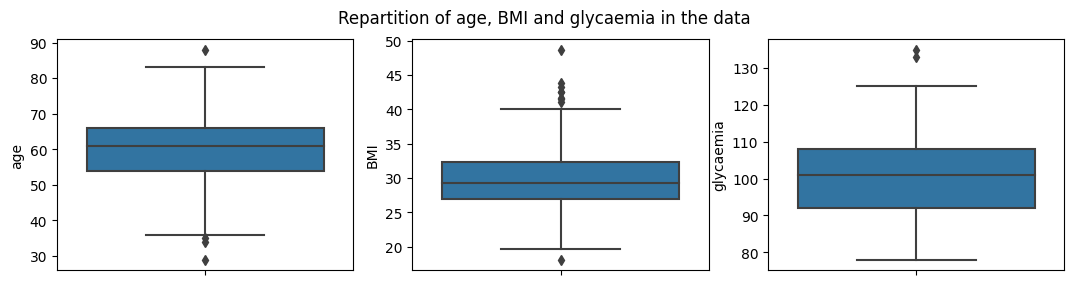

In [13]:
plt.figure(figsize=(13,3))
plt.suptitle("Repartition of age, BMI and glycaemia in the data")
plt.subplot(1,3,1)
sns.boxplot(data=X, y="age")
plt.subplot(1,3,2)
sns.boxplot(data=X, y="BMI")
plt.subplot(1,3,3)
sns.boxplot(data=X, y="glycaemia")

_Remark:_

the body mass index is often interpreted with the following range of values : underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more). According to our data, the analysed patients are mostly in overweight.
the value of glycaemia depends strongly on the moment of measurement (be fasting or having eaten before the measurement). A basal glycaemia (be fasting) is considered normal between 70 and 110mg/dL (approximately what we observe on our data, which is consistent with the high number of non-diabetic patients in our data).

In [14]:
X['T2DM'].value_counts()

False    191
True      17
Name: T2DM, dtype: int64

_Label variable_: 1 if the patient has been diagnosed type 2 diabetic / 0 if not

As we can see, our dataset is clearly desequilibrated, with a low number of diagnosed diabetic patients.

#### Bivariate statistics

We can first compare the distribution of the different variables according to diabetic-non diabetic diagnostic. As our data is desequilibrated, we can plot the distributions separting the data between T2DM and non T2DM patients.

<AxesSubplot: xlabel='BMI', ylabel='Percent'>

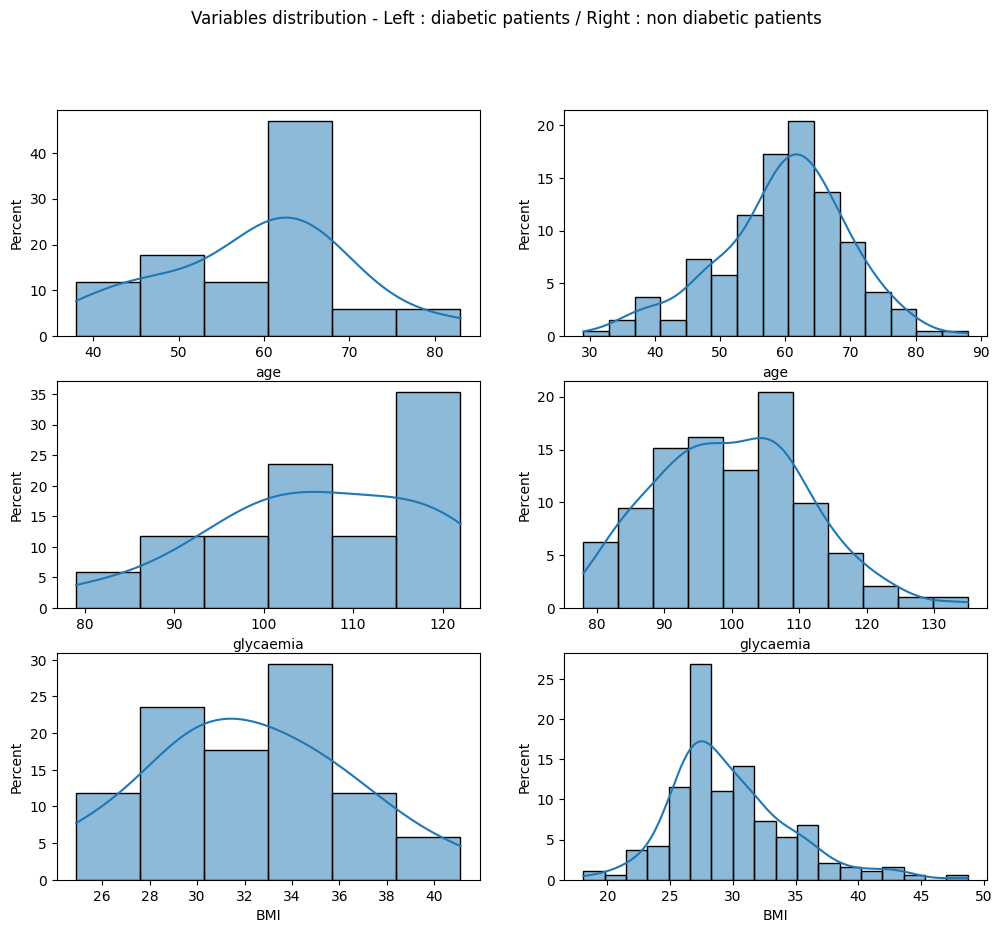

In [15]:
plt.figure(figsize=(12, 10))
plt.suptitle("Variables distribution - Left : diabetic patients / Right : non diabetic patients")
plt.subplot(3,2,1)
sns.histplot(data=X[X['T2DM']==True], x='age', stat="percent", kde=True)
plt.subplot(3,2,2)
sns.histplot(data=X[X['T2DM']==False], x='age', stat="percent", kde=True)
plt.subplot(3,2,3)
sns.histplot(data=X[X['T2DM']==True], x='glycaemia', stat="percent", kde=True)
plt.subplot(3,2,4)
sns.histplot(data=X[X['T2DM']==False], x='glycaemia', stat="percent", kde=True)
plt.subplot(3,2,5)
sns.histplot(data=X[X['T2DM']==True], x='BMI', stat="percent", kde=True)
plt.subplot(3,2,6)
sns.histplot(data=X[X['T2DM']==False], x='BMI', stat="percent", kde=True)

**COMMENT ABOUT THE PREVIOUS GRAPH <---- HERE**

As we can see on the previous graph, type 2 diabetes is more likely to appear for people around 60, but it can likely appear before around 40. We also see that type 2 diabetes is generally declared for people with high basal glycemia at the beginning of the study than with lower one. Finally, it seems that the BMI is slightly bigger on average for the type 2 diabetic people than for the non diabetic patients.

Therefore, these graphs motivate the interest in these clinical feature in the diagnosis. However, their distribution is significantly mixed between diabetic and non diabetic people, so we might certainly need handcrafted features from the CGM entries to improve the quality of the upcoming model.

We can also look at the potential relationship between the clinical variables, highlighting if the patient has diabete or not. First, we see on the scatter plots that no strong correlations appear in our data, meaning that on the 208 patients, BMI, age and basal glycaemia values are not particularly correlated.

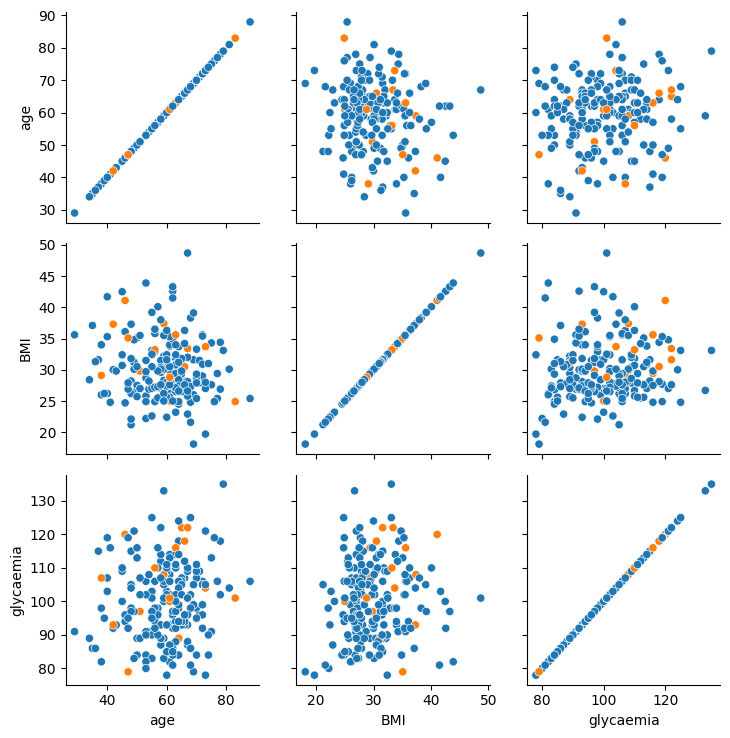

In [16]:
g = sns.PairGrid(X.drop(["gender", "HbA1c"], axis=1), hue="T2DM")
g.map(sns.scatterplot)

We can also compute the corresponding correlation coefficients, on the data composed of all patients, then on diabetic patients data and non diabetic patients data. The correlation values are really low, except for diabetic patients, for which we obtain correlation coefficients of a higher intensity. However, since we only have 17 diabetic patients, these values are not really relevant to study correlations.

<AxesSubplot: title={'center': 'Correlation matrix, non diabetic patients'}>

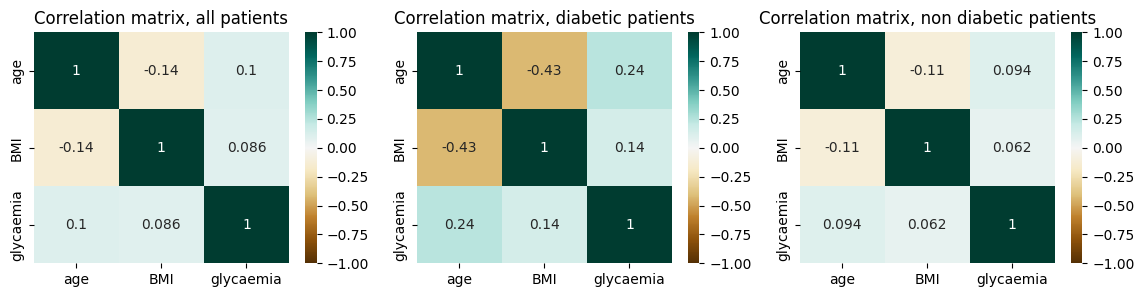

In [17]:
plt.figure(figsize=(14, 3))
plt.subplot(1,3,1)
plt.title("Correlation matrix, all patients")
sns.heatmap(data=X.iloc[:,1:4].corr(), vmin=-1, vmax=1, cmap="BrBG", annot=True)
plt.subplot(1,3,2)
plt.title("Correlation matrix, diabetic patients")
sns.heatmap(data=X[X['T2DM']==True].iloc[:,1:4].corr(), vmin=-1, vmax=1, cmap="BrBG", annot=True)
plt.subplot(1,3,3)
plt.title("Correlation matrix, non diabetic patients")
sns.heatmap(data=X[X['T2DM']==False].iloc[:,1:4].corr(), vmin=-1, vmax=1, cmap="BrBG", annot=True)

#### Focus on the HbA1c

##### Statistical analysis

The typical diagnosis of diabetes is done through HbA1c blood measurement, which characterizes the glucose value over 3 month. The threshold of 6.5% characterizes diabetic people according to most clinical procedures.

One can import the HbA1c measurements of the individual in our dataset. A statistical study is then proceeded.

In [18]:
from download_data import read_raw_clinical_data

def get_HbA1c_and_labels_data(path='.'):
    # First we fetch the clinical data
    clinical_data = read_raw_clinical_data(path)
    # Then we output the HbA1c and the labels dataframe, for each user, may it be missing or not
    return clinical_data[["HbA1c", "T2DM"]]

df_hba1c = get_HbA1c_and_labels_data()
df_hba1c.head()

,HbA1c,T2DM
1,6.3,False
2,5.8,False
3,5.5,False
4,6.0,False
5,5.2,False


<AxesSubplot: title={'center': 'Boxplot of HbA1c for diabetic and non diabetic patients'}, xlabel='T2DM', ylabel='HbA1c'>

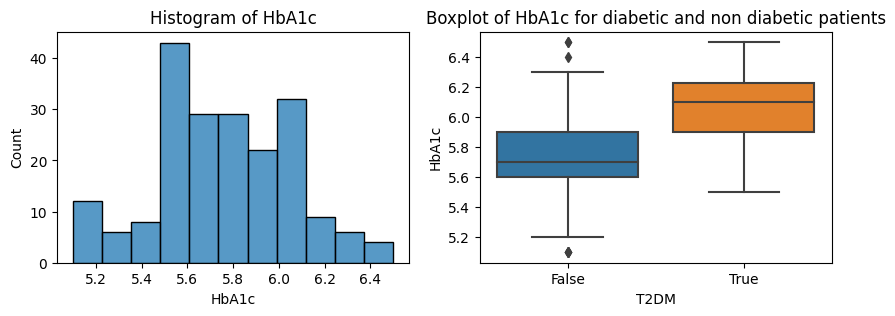

In [19]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title("Histogram of HbA1c")
sns.histplot(data=df_hba1c, x="HbA1c")
plt.subplot(1,2,2)
plt.title("Boxplot of HbA1c for diabetic and non diabetic patients")
sns.boxplot(data=df_hba1c, x="T2DM", y="HbA1c")

As expected, the repartition of HbA1c values is different whether the patient is diabetic or not.

One can compute the correlation ratio $\eta^2$ between the HBA1c and the T2DM in order to study their relationship between in the sample.

The correlation ratio is a statistical indicator that measures the intensity of the link between a quantitative variable and a qualitative variable. The conceptual framework for formalizing this intuition is the one-factor variance analysis equation. This equation breaks down the total variability (that of all the individuals) into an inter-class variability (difference between the mean of diabetics and the mean of non-diabetics) and an intra-class variability (variability within diabetics on the one hand and within non-diabetics on the other hand).
It is the percentage of variability (of the variable HbA1c) due to differences between classes (of the variable T2DM). This indicator varies between 0 (the classes have exactly the same mean: the variables are not linked) and 1 (the individuals of the same class have exactly the same value: the variables are perfectly linked since when we know the one, we know the other).

One obtains $\eta^2=0.08$, which is quite close to zero. Actually it was predictable as the average values of HbA1c in the two groups are close: 6.05 for diabetics and 5.73 for the others. In the sample, there is not a strong correlation between the two variables. This result is the contrary of what we find in the literature and we observe in the medical field. 

*Why doesn't one observe the same results?*

In the reference study, the diagnosis of T2DM was established with either basal glucose tests ≥ 126mg/dl, and/or haemoglobin A1c test ≥ 6.5%. The median follow–up was 33 months and ranged from 6 to 72 months. A possible reason why the Hb1Ac and the target variable T2DM are lowly correlated in the sample could be that for some individuals, the glycohemoglobin test has been done at a time where the patient was not diabetic for 3 months at least. It is also important the notice that among the 208 patients, 27 have a glycaemia between 110 and 125mg/dL and could be considered in a phase of pre-diabetes.


In [20]:
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2

    return  (ssb / (ssb + ssw))

df_hba1c_no_nan = df_hba1c.dropna()
eta = correlation_ratio(df_hba1c_no_nan['T2DM'], df_hba1c_no_nan['HbA1c'])
print('Eta_squared: {:.4f}\nEta: {:.4f}'.format(eta**2, eta))

Eta_squared: 0.0074
Eta: 0.0857


##### Filling missing values

Recall that we had a few missing entries in HbA1c. This situation will be adressed in the next section when introducing the CGM data.

However, one might note the procedure we are going to follow here. Indeed, it is possible to assess the HbA1c given the average glucose value of a patient (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4771657/) using the following formula of a regression model:

$$
\widehat{HbA}_{1c \text{ (%)}} = 0.0296 \times \widehat{\mu}_{glucose \text{ (mg/dl)}} + 2.419
$$

Hence, since we have continuous glucose entries for 24h at least for each patient, it is possible to get an estimate of the average glucose and compute an estimation of the HbA1c. However, note that we didn't get 3 months of data to compute this average glucose value, so it might not be perfectly relevant but it's the best shot we have.

In [21]:
def estimate_HbA1c(cgm_data):
    return 0.0296 * cgm_data.mean(axis=1) + 2.419

We will dive in the comparison between this estimation and the value we have once we introduce the CGM data.

#### CGM Data

For each patient, we have a continuous glucose time serie of length 24h or 48h. These are produced by CGM sensors as described in the introduction.

Let's import one of the users raw CGM data so we can have a look.

<AxesSubplot: >

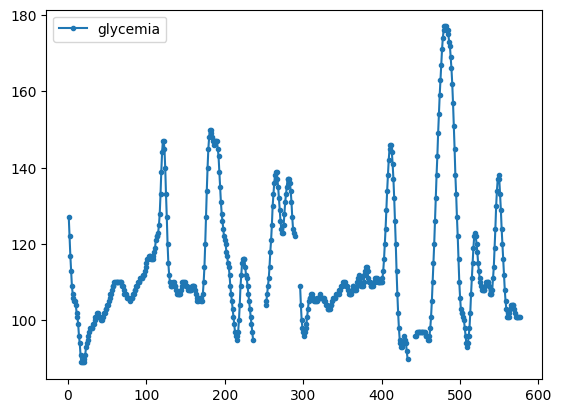

In [22]:
from download_data import get_cgm_data as get_raw_cgm_data

raw_cgm_data = get_raw_cgm_data(6)
raw_cgm_data.plot(marker='.', linestyle='-')

##### Interpolation of the Continuous Glucose values

As we can see on the previous curve, we might have some situations in which the CGM is not capturing the blood sugar value for various reasons (disconnection, high pressure on the measurement area, out of measurement area, ...).

Interpolation is a method widely used to estimate missing CGM data by predicting values that would have been recorded if the sensor had not failed (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3692219/).

There are several methods for interpolation of missing CGM data, but the choice of method depends on the nature of the data and the goals of the analysis. For our application, we use the Linear interpolation method that has been accepted by the medical community through multiple grid systems (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2903980/). This method estimates missing values by connecting the neighboring observed values with a straight line. It assumes that the glucose values change linearly over time, which is also widely verified by short term linear forecasting of blood glucose models that are able to achieve impressive accuracy (15 minutes being a short range for instance).

Some other commonly used interpolation methods are:

- The cubic spline interpolation: This method estimates missing values by fitting a smooth curve to the observed data using cubic polynomials. Cubic spline interpolation assumes that the glucose values change smoothly over time.

- The Kalman filter (smoothing): This method estimates missing values by using a gaussian prior model that predicts the glucose values based on the observed data and the known properties of the system. Kalman filter interpolation assumes that the glucose values follow a gaussian stochastic process. This method has been widely in used recently to interpolate Glucose data.

<AxesSubplot: >

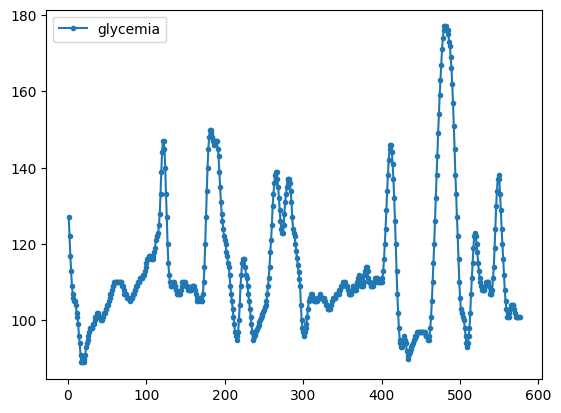

In [23]:
cgm_data_interp = raw_cgm_data.interpolate(method="linear")
cgm_data_interp.plot(marker='.', linestyle='-')

The interpolation is preprocessed when running the `download_data.py` script that generates the `external_data.csv` file, which contains preprocessed CGM time series of each person in the dataset.

These time series are either of length 48h or 24h, depending on how long the sensor was attached to the patient. For simpler data management, the `external_data.csv` contains the dataframe of the time series of with `NaN` values after 24h length if no data is recorded.

<AxesSubplot: >

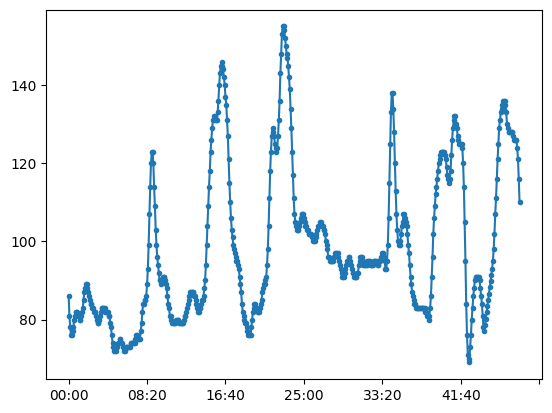

In [24]:
def get_cgm_data(path='./'):
    data = pd.read_csv('external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id, path='./'):
    cgm_data = get_cgm_data(path)
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

cgm_data = get_patient_cgm_data(1)
cgm_data.plot(label='glycemia', marker='.')

##### HbA1c: Filling missing entries

Now that we have introduced the CGM data, we can look into the estimation of HbA1c we introduced previously, and see how it behaves in comparison with the values we have.

Mean absolute difference (estimation/true): 0.42%
Max absolute difference (estimation/true): 1.75%


<AxesSubplot: ylabel='Density'>

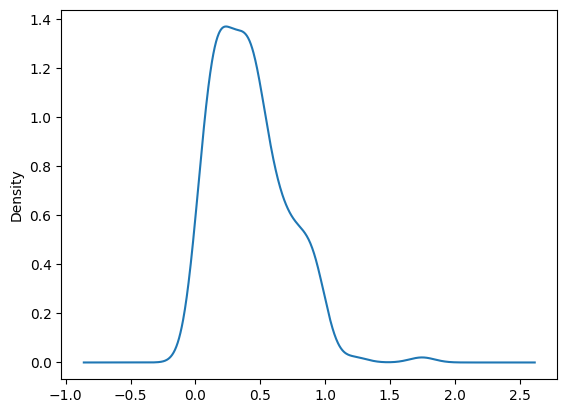

In [25]:
# Computing the estimation of the HbA1c for each individual using the CGM data
all_cgm_data = get_cgm_data()
estimated_HbA1c = estimate_HbA1c(all_cgm_data)

# Comparison with values we already have
diff = (X["HbA1c"] - estimated_HbA1c).apply(np.abs)

print("Mean absolute difference (estimation/true): {:0.2f}%".format(diff.mean()))
print("Max absolute difference (estimation/true): {:0.2f}%".format(diff.max()))

diff.plot(kind='kde')

As it seems, this estimation isn't absurd and we can safely use it to fill the missing values with the following code, as it's the closest we would get to the medical entry.

In [26]:
hba1c_missing = X[X["HbA1c"].isna()] 
for index in hba1c_missing.index:
    X['HbA1c'][index] = estimated_HbA1c[index]

C:\Users\frigi\AppData\Local\Temp\ipykernel_4244\3969388491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HbA1c'][index] = estimated_HbA1c[index]


##### Observation on hyperglycemic events

What characterizes a non-treated diabetic individual is hyperglycemia. This is the symptom of diabetes that leads to most complications of the disease, and it corresponds to a value of the glycemia that is superior to 150 mg/L.

Moreover, the hyperglycemia is supposedly not reachable by an individual that isn't affected by pre-diabetic symptoms, or isn't diabetic. Hence, it is quite in our interest to vizualize these areas when they exist in the CGM time series.

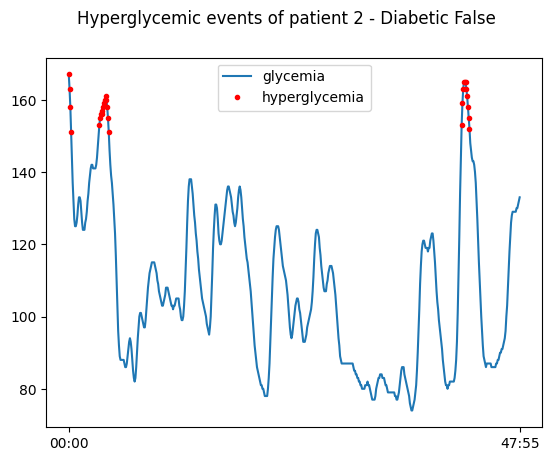

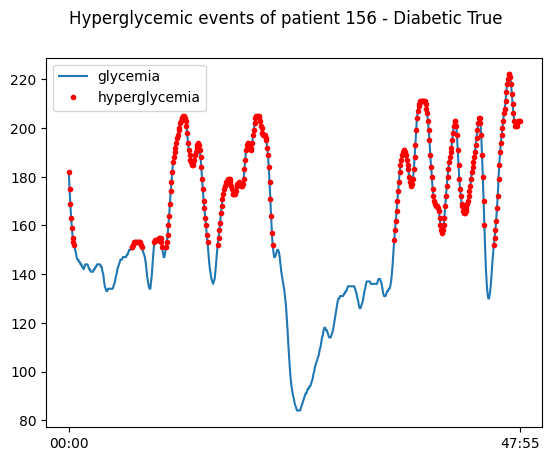

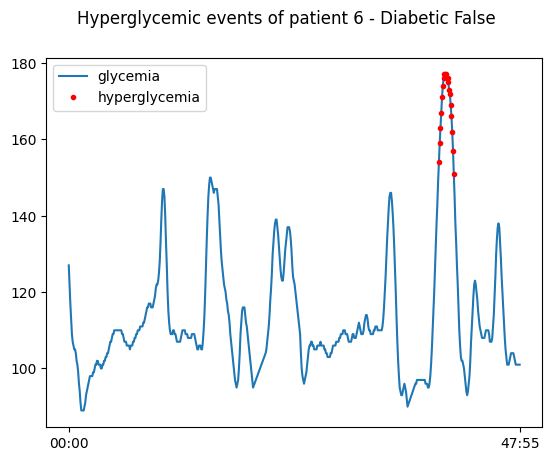

In [27]:
def hyperglycemic_events(patient_id_list):
    
    for patient_id in patient_id_list:
        cgm_user = get_patient_cgm_data(patient_id)
        
        fig, axs = plt.subplots()
        
        axs.plot(cgm_user.index.values, cgm_user.values, label='glycemia')
        axs.set_xticks([cgm_user.index.values[0], cgm_user.index.values[-1]])
        
        hyper_glycemic = cgm_user[cgm_user > 150]
        axs.plot(hyper_glycemic.index, hyper_glycemic.values, label="hyperglycemia", color='r', linestyle='', marker='.')
        axs.legend()
        
        fig.suptitle(f"Hyperglycemic events of patient {patient_id} - Diabetic {X['T2DM'].loc[patient_id]}")
        
hyperglycemic_events([2, 156, 6])

As we can see, not all patients have hyperglycemic events, neither it is exactly deterministic in their diagnosis. However, we do observe that people that were diagnose with the disease do have a much higher average time in hyperglycemia than others.

##### Statistics and handcrafted feature extraction on the CGM data

We would like to handcraft some statistical features that might be relevant for predicting eventual diabetes using the CGM input.

First, let's count how many of these time series are only 24h long, and see to which individual they belong to.

In [28]:
all_cgm_data = get_cgm_data()
nan_cgm_rows = all_cgm_data[all_cgm_data.isna().any(axis=1)]

print(f'Number of 24h long time series: {len(nan_cgm_rows)}/{len(all_cgm_data)}')

nan_entries_diabetics = y[nan_cgm_rows.index - 1]

print(f'Number of diabetics among these: {nan_entries_diabetics.sum()}/{len(nan_entries_diabetics)}')

Number of 24h long time series: 17/208
Number of diabetics among these: 0/17


Let's try making some interesting statistics on these time series, so we can extract relevant features that characterizes well diabetics.

<AxesSubplot: xlabel='label', ylabel='cgm_max'>

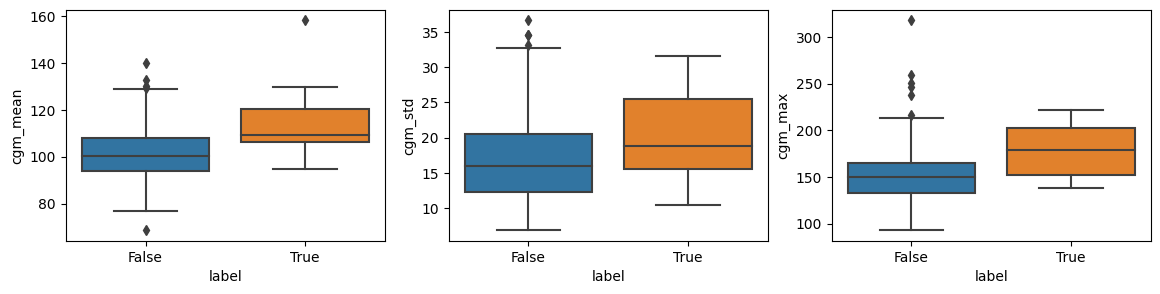

In [29]:
stats = pd.DataFrame(index=all_cgm_data.index)

stats["label"] = y[all_cgm_data.index - 1]
stats["cgm_mean"] = list(all_cgm_data.mean(axis=1))
stats["cgm_max"] = list(all_cgm_data.max(axis=1))
stats["cgm_std"] = list(all_cgm_data.std(axis=1))

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="cgm_mean")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="cgm_std")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="cgm_max")

We can see that descriptive statistics of the CGM time series could be use for differenciation between diabetic and non diabetic patients. Diabetic patients tend to have a higher mean of glucose value during the day, and reach higher maximum than non diabetic people, being a symptom of the disease.

We can implement a large variety of metrics to analyse this CGM data. It could be interesting to understand the time spent by patients in hyperglycemia or normal range, as a percentage of a day for example. The following functions allow to consider the proportion of the day spent by the patient in the normal interval glycemia and above.

<AxesSubplot: xlabel='label', ylabel='time_in_hyperglycemia'>

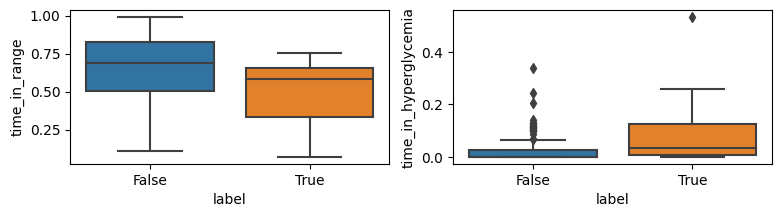

In [30]:
def compute_average_time_in_range(cgm_val, normal_range=[70, 110]):
    col_in_range = cgm_val[(cgm_val >= normal_range[0]) & (cgm_val <= normal_range[1])]
    return len(col_in_range)/len(cgm_val)

def compute_average_time_above(cgm_val, value=150):
    col_above = cgm_val[(cgm_val > value)]
    return len(col_above)/len(cgm_val)

stats["time_in_range"] = all_cgm_data.apply(compute_average_time_in_range, axis=1)
stats["time_in_hyperglycemia"] = all_cgm_data.apply(compute_average_time_above, axis=1)

plt.figure(figsize=(14,2))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="time_in_range")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="time_in_hyperglycemia")

We can also handcraft other maybe relevant features on CGM time series as:
- Area under the CGM curve: typically, we might expect this area to be higher for non-treated diabetic patients, as they are higher on average.
- Skewness: typical asymetrical characteristic of a CGM time serie.
- Different percentiles (here 3rd quantile): typical statistic on a time serie

Note that we need to normalize the _area under the cgm curve_ by the serie length, so that its meaning and interpretation would be the same if the patient has 24h or 48h of CGM data. For the mean, variance, skewness or proportion above a certain glucose value for example, there is no need to post-process the value as they are already comparable for different length of series.

We also need to be careful with computations of those features with missing values: some pandas functions may return _NaN_ that we need to avoid.

<AxesSubplot: xlabel='area_under_cgm_norm_points', ylabel='area_under_cgm_norm_48h'>

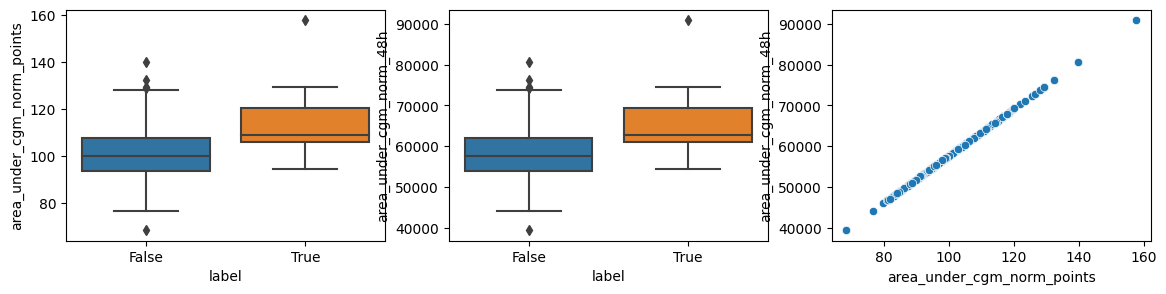

In [31]:
from numpy import trapz
def area_norm_points(cgm_val):
    if cgm_val.isna().sum() !=0:
        area = trapz(cgm_val[:288])/288
    else:
        area = trapz(cgm_val)/576
    return area

def area_norm_48h(cgm_val):
    if cgm_val.isna().sum() !=0:
        area = trapz(cgm_val[:288])*2
    else:
        area = trapz(cgm_val)
    return area

stats["area_under_cgm_norm_points"] = all_cgm_data.apply(area_norm_points, axis=1)
stats["area_under_cgm_norm_48h"] = all_cgm_data.apply(area_norm_48h, axis=1)

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="area_under_cgm_norm_points")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="area_under_cgm_norm_48h")
plt.subplot(1,3,3)
sns.scatterplot(data=stats, x='area_under_cgm_norm_points', y="area_under_cgm_norm_48h")

As we can see, the two normalisation approaches for area under CGM curve are completely equivalent. Patients with Type 2 diabetes may have a higher area under their CGM curve, probably because they are more subject to high values of glucose (hyperglycemia) and maybe more variability than healthy patients.

Let's focus on the other statistics: quantiles or asymmetry of the distribution (skewness). According to the graphs, skewness (asymmetry of CGM distribution) does not seem to be an important feature for Type 2 diabetic and non diabetic patients distinction. The first and third quartile seem to be higher in the glucose measurements time series for Type 2 diabetic patients, which confirm the results obtained until now on potential hyperglycaemia higher for T2 diabetic pateints.

<AxesSubplot: xlabel='label', ylabel='Q3'>

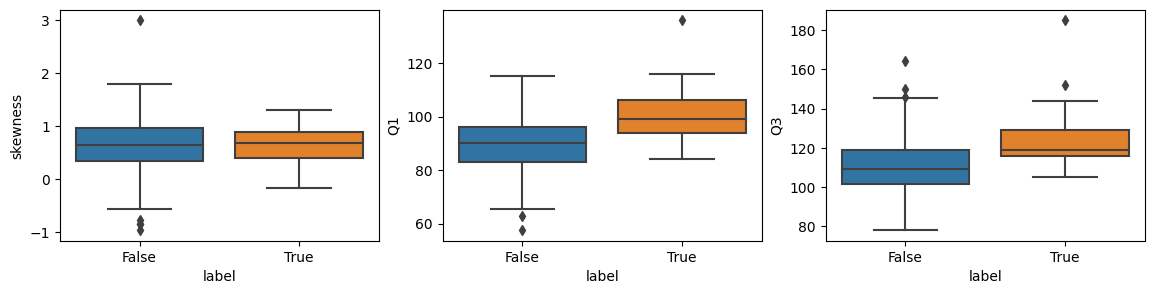

In [32]:
stats["skewness"] = list(all_cgm_data.skew(axis=1))
stats["Q1"] = list(all_cgm_data.quantile(0.25, axis=1))
stats["Q3"] = list(all_cgm_data.quantile(0.75, axis=1))

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="skewness")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="Q1")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="Q3")

In [33]:
stats.isna().sum()

label                         0
cgm_mean                      0
cgm_max                       0
cgm_std                       0
time_in_range                 0
time_in_hyperglycemia         0
area_under_cgm_norm_points    0
area_under_cgm_norm_48h       0
skewness                      0
Q1                            0
Q3                            0
dtype: int64

The article also mentions entropy measures : Approximate (ApEn) and Sample (SampEn) entropies, that can be computed creating new functions, such as the example below found on https://en.wikipedia.org/wiki/Sample_entropy (Warning : the computation time can be long).

Entropy metrics assess the predictability of the time series : how the preceding points determine the following ones. A high sample entropy implies less predictability accross the series, and thus a higher complexity (possibly linked to Type 2 diabetes for glucose measurements). This pattern is not really clear on our data, but this feature could be useful to consider in a machine learning model in combination with others.

<AxesSubplot: xlabel='label', ylabel='Sample Entropy'>

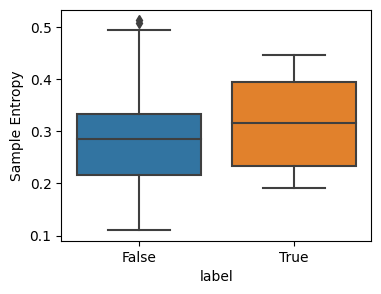

In [34]:
def sample_entropy(L, m=2, r=3):
    """Sample entropy."""
    N = len(L)
    B = 0.0
    A = 0.0
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])
    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])
    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])
    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    # Return SampEn
    return -np.log(A / B)

stats["Sample Entropy"] = list(all_cgm_data.apply(sample_entropy, axis=1))
plt.figure(figsize=(4,3))
sns.boxplot(data=stats, x='label', y="Sample Entropy")

Finally, another type of metrics considered in the paper are the ones derived from the Poincaré plot.

Poincaré plot assign each point on the x-axis to the following point in the series on the y-axis. The obtained cloud of points is then fitted to an ellipse, from which we can derive the standard deviation with respect to the horizontal axis of the fitted ellipse (SD1), and the vertical one (SD2). (_Henriques et al., 2014 : “Glucose-at-a-Glance”: New Method to Visualize the Dynamics of Continuous Glucose Monitoring Data_, https://journals.sagepub.com/doi/10.1177/1932296814524095). We can consider only 24 hours of data for each patient for these features to be consistent, or find a normalisation way to consider time series of 24 and 48 hours as detailed before. We will focus on the latter case (normalization to 48h), since we have so few 24h series (17, non of them being diabetic).

In [35]:
from matplotlib.patches import Ellipse
def plot_poincare(cgm_data, plot=False):
    cgm_data_n = np.array(cgm_data[:-1])
    cgm_data_n1 = np.array(cgm_data[1:])

    sd1 = np.sqrt(0.5) * np.std(cgm_data_n1 - cgm_data_n)
    sd2 = np.sqrt(0.5) * np.std(cgm_data_n1 + cgm_data_n)

    if plot == True:
        m = np.mean(cgm_data_n)
        min_cgm = np.min(cgm_data_n)
        max_cgm = np.max(cgm_data_n)
        
        plt.figure(figsize=(5, 5))
        plt.title("Poincare plot")
        sns.scatterplot(x=cgm_data_n, y=cgm_data_n1, color="#51A6D8")

        plt.xlabel(r'$glucose_n (mg/dL)$')
        plt.ylabel(r'$glucose_{n+1} (mg/dL)$')

        e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
        plt.gca().add_patch(e1)

        plt.arrow(m, m, (max_cgm-min_cgm)*0.4, (max_cgm-min_cgm)*0.4, color="k", head_length=2, head_width=2)
        plt.arrow(m, m, (min_cgm-max_cgm)*0.4, (max_cgm-min_cgm)*0.4, color="k", head_width=2, head_length=2)

        plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=1, label="SD2")
        plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=1, label="SD1")
        plt.legend()
    
    return sd1, sd2

def sd1_fun(cgm_val):
    # consider only 24 hours of data for each patient
    cgm_val = cgm_val[:288]
    cgm_data_n = np.array(cgm_val[:-1])
    cgm_data_n1 = np.array(cgm_val[1:])

    sd1 = np.sqrt(0.5) * np.std(cgm_data_n1 - cgm_data_n)
    return sd1

def sd2_fun(cgm_val):
    # consider only 24 hours of data for each patient
    cgm_val = cgm_val[:288]
    cgm_data_n = np.array(cgm_val[:-1])
    cgm_data_n1 = np.array(cgm_val[1:])

    sd2 = np.sqrt(0.5) * np.std(cgm_data_n1 + cgm_data_n)
    return sd2

SD1: 1.705 ms
SD2: 27.710 ms


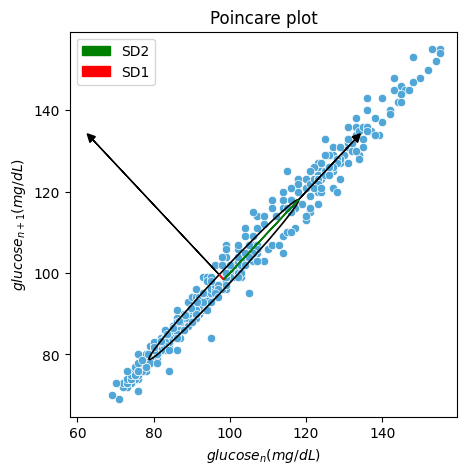

In [36]:
sd1, sd2 = plot_poincare(all_cgm_data.loc[1,:], plot=True)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

<AxesSubplot: xlabel='label', ylabel='ellipse_quot'>

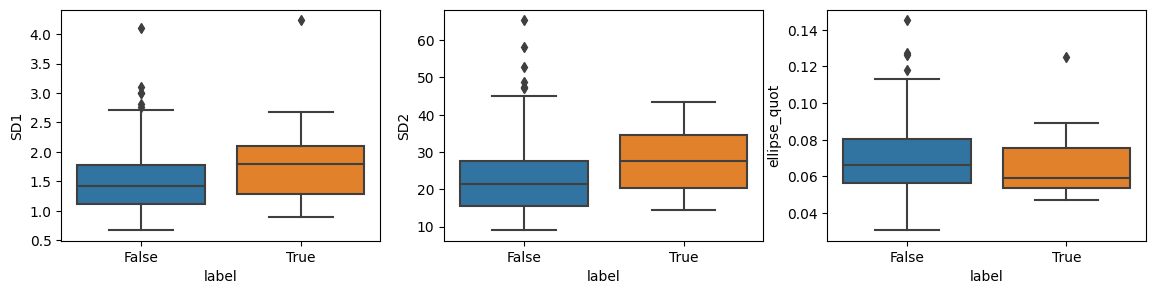

In [37]:
stats["SD1"] = list(all_cgm_data.apply(sd1_fun, axis=1))
stats["SD2"] = list(all_cgm_data.apply(sd2_fun, axis=1))
stats["ellipse_quot"] = stats["SD1"]/stats["SD2"]

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="SD1")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="SD2")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="ellipse_quot")

Looking at the previous boxplots, these features seem not to be key factors to differentiate Type 2 diabetic from non diabetic patients. It can be possible that the predictability of a glucose value according to the previous ones is not discriminating patients according to the presence of diabetes or not.

We can also try to consider the glucose level at different times of the day (NB : the first value corresponds to the one measured at midnight for the first day). We can for example consider windows of 8 hours (to divide 48 hours in 3).

So we can compute these features in our pipeline, we would put them into a wrapper of functions in our notebook. In practice, these functions are implemented in the `estimator.py` within the `FeatureExtractor` as follows.

In [38]:
def compute_variance(cgm_data):
    return cgm_data.var()

def compute_mean(cgm_data):
    return cgm_data.mean()

def compute_average_time_in_range(cgm_data, normal_range=[70, 127]):
    index_in_range = cgm_data[(cgm_data >= 70) & (cgm_data <= 127)].index
    return len(index_in_range)/len(cgm_data.index)

def compute_maximum(cgm_data):
    return cgm_data.max()

additional_features = {
    "CGM Variance":compute_variance,
    "CGM Mean": compute_mean,
    "CGM Time in range": compute_average_time_in_range,
    "CGM Maximum": compute_maximum,
}

print("Extracted features:")
for name, fun in additional_features.items():
    print(f'  * {name}: {fun(cgm_data)}')

Extracted features:
  * CGM Variance: 385.6137850241557
  * CGM Mean: 98.42013888888889
  * CGM Time in range: 0.8802083333333334
  * CGM Maximum: 155.0


These new features regarding the patients are part of the data exploration we can do on the CGM time series, to finally determine whether the patient is going to be DT2 or not in addition to the clinical data.

Other suggestions could be implemented: looking at postprandial overall values (that would use more of the time serie structure), night mean value, day mean value, day variance, etc...

##### Deep crafted features

Time series analysis has always been challenging, as the complexity of the entries and the characteristics are often difficult to unveil and analyse. Previously, we have been trying to extract relevant features through medical knowledge we found on type 2 diabetes, and usually relevant characteristics of time series. However, it is very likely that we couldn't grasp every relevant insights on the data ourselves, especially the CGM ones are still much unexplored.

To attend that issue, we propose to extract relevant features using CNN architectures that have proven their efficiency on multiple tasks for time series analysis (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9040363/). The specific architecture we have in mind, is to build a latent space of given dimension from which will extract features. This can namely be achieved by Auto-encoder architectures, Variational Auto-Encoders, GANs, etc.

The idea of these 2 architectures is to build a first model (CNN in our case), that is called the encoder, which pushes the data into a latent space of our design. Then, we have a decoder (another CNN) that takes the data from the latent space to rebuild the original data. Once that model (encoder + decoder) is well trained, we can take only the encoder part to build latent features that might be useful for our analysis.

In [39]:
import torch

class Autoencoder(torch.nn.Module):
    def __init__(
            self,
            input_size,
            conv_layers,
            conv_sizes,
            hidden_layers_encoder,
            hidden_layers_decoder,
            latent_dim,
            dropout
    ):
        super(Autoencoder, self).__init__()
        
        # We first have a convolution net, then the encoder dense part (conv net + dense = encoder), then the decoder (dense)
        conv_layers = [1] + conv_layers
        self.conv_net = []
        for i in range(0, len(conv_layers)-1):
            self.conv_net += [
                torch.nn.Conv1d(conv_layers[i], conv_layers[i+1], kernel_size=conv_sizes[i], padding='same'),
                torch.nn.BatchNorm1d(conv_layers[i+1]),
                torch.nn.Dropout(dropout),
                torch.nn.ReLU()
            ]
        # Flattening the output of the convolutional part
        self.conv_net += [torch.nn.Flatten(start_dim=1)]

        self.encoder = []
        self.decoder = []

        hidden_layers_encoder = [conv_layers[-1] * input_size] + hidden_layers_encoder + [latent_dim]
        hidden_layers_decoder = [latent_dim] + hidden_layers_decoder + [input_size]

        for i in range(0, len(hidden_layers_encoder)-1):
            self.encoder += [
                torch.nn.Linear(hidden_layers_encoder[i], hidden_layers_encoder[i+1]),
                torch.nn.ReLU()
            ]

        for i in range(0, len(hidden_layers_decoder)-1):
            self.decoder += [
                torch.nn.Linear(hidden_layers_decoder[i], hidden_layers_decoder[i+1]),
                torch.nn.ReLU()
            ]

        self.conv_net = torch.nn.Sequential(*self.conv_net)
        self.encoder = torch.nn.Sequential(*self.encoder)
        self.decoder = torch.nn.Sequential(*self.decoder)

        self.loss_fn = torch.nn.MSELoss()

    def forward(self, x):
        h = self.conv_net(x)
        encoded = self.encoder(h)
        decoded = self.decoder(encoded)
        return decoded


def train(model, optimizer, data_train_loader, n_epoch):
    for epoch in range(n_epoch):

        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_train_loader):
            optimizer.zero_grad()

            reconstructed = model(data)
            loss = model.loss_fn(reconstructed.view(reconstructed.shape[0], 1, reconstructed.shape[1]), data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        if epoch % 10 == 0:
            print('[*] Epoch: {} - Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))

    return model

def train_no_batch(model, optimizer, dataset, n_epoch):
    
    for epoch in range(n_epoch):
        
        train_loss = 0
        
        for i, cgm_entry in dataset.iterrows():
            # We don't want NaN entries to be learnt
            if (cgm_entry.isna().any()):
                continue
            cgm_tensor = torch.tensor(cgm_entry.values.reshape(1, -1), dtype=torch.float32)
            reconstructed = model(cgm_tensor)
            loss = model.loss_fn(
                reconstructed, 
                cgm_tensor
            )
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        if epoch % 10 == 0:
                print('[*] Epoch: {} - Average loss: {:.4f}'.format(epoch, train_loss))
    
    return model

In [40]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from problem import get_train_data, get_test_data

class CGM_dataset(Dataset):
    """
    Helper class to build a dataset using pytorch
    """
    def __init__(self, cgm_data):
        self.x = torch.tensor(np.expand_dims(cgm_data.to_numpy(), axis=1), dtype=torch.float32)
        self.y = torch.tensor(np.expand_dims(cgm_data.to_numpy(), axis=1), dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# We fetch the cgm data
all_cgm_data = get_cgm_data()

# For now we get rid of the 24h long CGM entries only for our analysis
all_cgm_data = all_cgm_data.dropna(axis=0)

# Building the datasets
train_cgm_data = CGM_dataset(all_cgm_data)
train_loader = DataLoader(train_cgm_data, batch_size=32, shuffle=False)

# Building the model
model = Autoencoder(
    input_size=576,
    conv_layers=[],
    conv_sizes=[],
    hidden_layers_encoder=[256, 128],
    hidden_layers_decoder=[128, 256],
    latent_dim=128,
    dropout=0.1
)

optimizer = torch.optim.Adam(model.parameters(), lr=10e-4, weight_decay=10e-7)

# Training
train(model, optimizer, train_loader, n_epoch=100)
#train_no_batch(model, optimizer, all_cgm_data, n_epoch=100)

[*] Epoch: 0 - Average loss: 289.7178
[*] Epoch: 10 - Average loss: 104.3351
[*] Epoch: 20 - Average loss: 89.4065
[*] Epoch: 30 - Average loss: 75.3867
[*] Epoch: 40 - Average loss: 16.2507
[*] Epoch: 50 - Average loss: 9.1453
[*] Epoch: 60 - Average loss: 9.1093
[*] Epoch: 70 - Average loss: 8.8950
[*] Epoch: 80 - Average loss: 7.9454
[*] Epoch: 90 - Average loss: 7.8305


Autoencoder(
  (conv_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=576, bias=True)
    (5): ReLU()
  )
  (loss_fn): MSELoss()
)

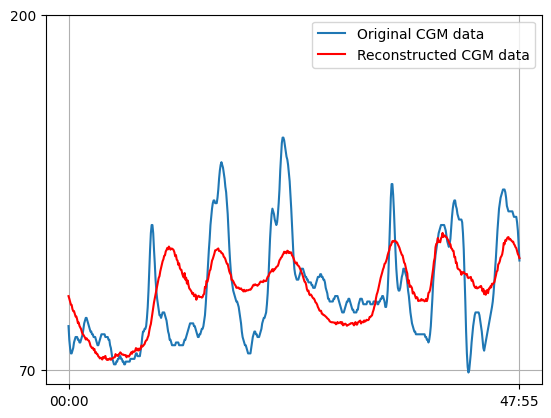

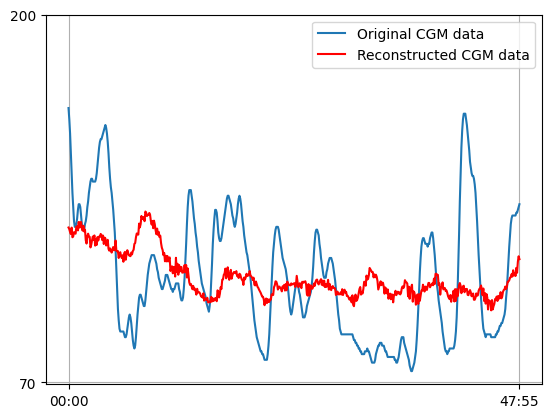

In [41]:
max_plot = 2
for i, cgm_entry in all_cgm_data.iterrows():
    
    rec_data = model(torch.tensor(cgm_entry.values, dtype=torch.float32).view(1, 1, -1))
    rec_data = rec_data.detach().numpy().squeeze()
    
    fig, axs = plt.subplots()
    axs.plot(cgm_entry, label="Original CGM data")
    axs.plot(rec_data, label="Reconstructed CGM data", color="r")
    axs.set_xticks([cgm_entry.index.values[0], cgm_entry.index.values[-1]])
    axs.set_yticks([70, 200])
    axs.grid()
    axs.legend()
    
    max_plot -= 1
    if max_plot <= 0:
        break

plt.show()

Explanation of the results of AE

##### Medical research features

The paper from which the data is extracted studies the advantage of using Detrended Fluctuation Analysis (DFA) in the prediction of the risk of developing T2DM. One of the main results is that a high DFA scale component increases the risk of developing T2DM.  Detrended Fluctuation Analysis (DFA) is a signal processing technique that can be used to analyze short, medium and long-term correlations in a time series. In particular, the article suggests that DFA can contain information on subtle changes in the correlation structure of glucose levels that are not apparent using standard statistical methods on the whole time series.

DFA analyzes how the information content of a time series is distributed across time windows. Indeed, the loss of complexity of the results is a first sign of the presence of disease. A complex time series will have proportionally more information encoded in the smaller time windows. As the system degrades, its ability to detect and respond to small changes diminishes, and thus the information content of small time windows decreases. Thus, the decrease in complexity leads to an increase in the exponent of the DFA scale.

To evaluate the pertinence of the developed metrics, the authors use a Cox proportional hazard model to predict the risk of T2DM. They study the coefficients of this model using different metrics potentially linked to diabete such as (among others) CONGA-2 (standard deviation of the range of differences in glycaemia between points separated by 120 min) or MAGE (glycaemic excursion : excursion greater than 1 SD of the CGM time series).
The authors conclude by studying the coefficients of the model and their significance that the DFA $\alpha$ component “has significant predictive power on the development of T2DM in patients at risk, independently of other variability metrics, omitting pre–treatment through integration”. To construct this indicator, they conducted a study on pre-treatment of CGM time series or not before DFA exponent computation, and on the sizes of the width of the smallest and the largest windows to consider for the DFA. 

Our idea is to adapt the following approach: instead of using a Cox model and studying the performance of the different metrics separately, we could extract features from the CGM series, combine them with clinical data for each patient and use a machine learning model to predict if the patient will be diagnosed Type diabetic or not.

## Building predictive models

First we fetch the training and testing sets

In [42]:
from problem import get_train_data, get_test_data

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

For submitting to the [RAMP site](https://ramp.studio), you will need to create a `estimator.py` file that defines a `get_estimator` function which returns a scikit-learn estimator.

The initial example classifier in your sandbox is:

In [43]:
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Functions to fetch the CGM data and plug new features in the dataset taken from the series
def get_cgm_data():
    data = pd.read_csv('external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id):
    cgm_data = get_cgm_data()
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

def add_cgm_feature(clinical_data, feature_name, compute_feature_function):
    n_individuals = len(clinical_data)
    feature_column = np.zeros((n_individuals,))

    for i, user_id in enumerate(clinical_data.index.values):
        cgm_data = get_patient_cgm_data(int(user_id))
        feature = compute_feature_function(cgm_data)
        feature_column[i] = feature

    clinical_data[feature_name] = feature_column
    return clinical_data

# Wrapper for the feature extraction
class FeatureExtractor:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        for name, fun in additional_features.items():
            X = add_cgm_feature(X, name, fun)
        return X

# Minimal preprocessing of the data
def get_preprocessing():
    return preprocessing.StandardScaler(), preprocessing.MinMaxScaler()
            
def get_estimator():
    
    feature_extractor = FeatureExtractor()
    
    classifier = RandomForestClassifier(
        n_estimators=50, random_state=61
    )
    
    pipe = make_pipeline(
        feature_extractor,
        *get_preprocessing(),
        classifier
    )
    
    return pipe

In [44]:
feature_extractor = FeatureExtractor()
feature_extractor.transform(X_train)

,gender,age,BMI,glycaemia,HbA1c,CGM Variance,CGM Mean,CGM Time in range,CGM Maximum
patient_id,,,,,,,,,
205,0.0,58.0,38.0,107.0,5.8,618.816411,118.282986,0.750000,213.0
54,1.0,63.0,29.1,97.0,5.9,707.551446,101.071181,0.682292,164.0
169,1.0,63.0,27.1,92.0,5.7,322.269843,100.149306,0.902778,168.0
166,1.0,59.0,26.2,106.0,5.6,189.269490,86.397569,0.852431,133.0
102,0.0,55.0,32.4,90.0,5.7,133.751111,117.111111,0.800347,155.0
...,...,...,...,...,...,...,...,...,...
158,0.0,61.0,30.5,87.0,5.9,112.498247,91.616319,0.994792,128.0
67,0.0,58.0,27.0,114.0,6.1,124.931002,94.892361,0.998264,128.0
177,0.0,48.0,31.8,97.0,5.4,542.006908,111.006944,0.809028,172.0


When developing locally, you can use `scikit-learn` tools to test a given model.

In [45]:
from sklearn.model_selection import cross_val_score
from problem import get_cv

#cv = get_cv(X_train, y_train)
#cross_val_score(get_estimator(), X_train, y_train, cv=cv)

You could easily train an test a model and the respective datasets.

In [ ]:
model = get_estimator()
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

In [ ]:
import sklearn.metrics as metrics

metrics_list = {
    "Balanced Accuracy":metrics.balanced_accuracy_score, 
    "F1":metrics.f1_score, 
    "Precision":metrics.precision_score, 
    "Recall":metrics.recall_score
}

for name, metric in metrics_list.items():
    print(f"* {name}: {metric(y_true, y_pred)}")

print("Confusion matrix")
metrics.confusion_matrix(y_true, y_pred)

In [ ]:
print(y_pred)

# Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)